In [13]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

video = input("Input video file")
cap = cv2.VideoCapture(video)
success, prev = cap.read()
if not success:
    raise Exception("Failed to read video")

In [14]:
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
HORIZONTAL_BORDER_CROP = 20
vert_border = int(HORIZONTAL_BORDER_CROP * prev.shape[0] / prev.shape[1])

# Process noise standard deviation (pstd) and measurement noise standard deviation (cstd)
pstd, cstd = 4e-3, 0.25

# Process noise covariance matrix (Q) and measurement noise covariance matrix (R)
Q = np.array([pstd, pstd, pstd])
R = np.array([cstd, cstd, cstd])

# Initial state vector (X) and initial covariance matrix (P)
X = np.zeros(3)
P = np.ones(3)

trajectory = []
smoothed_trajectory = []
new_transforms = []
prev_to_cur_transform = []

# tracking transformations and trajectory
last_T = None  # last transformation matrix
x = y = a = 0  # a is angle
k = 1  # frame counter

In [15]:
fourcc = cv2.VideoWriter_fourcc(*"mp4v") 
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out_stab = cv2.VideoWriter(
    "stabilized_output.mp4", fourcc, fps, (frame_width, frame_height)
)


In [16]:
# The algorithm performs video stabilization using feature tracking and affine transformations.
# 1. It reads frames from the video and converts them to grayscale.
# 2. It detects good features to track in the previous frame and tracks them in the current frame using optical flow.
# 3. It estimates an affine transformation matrix between the previous and current frames.
# 4. The transformation parameters (translation and rotation) are accumulated to compute the trajectory.
# 5. A Kalman filter is applied to smooth the trajectory by reducing noise.
# 6. The smoothed trajectory is used to adjust the transformation parameters, creating a stabilized frame.
# 7. The stabilized frame is cropped and resized to match the original frame dimensions.
# 8. The process repeats for all frames, and the stabilized video is displayed side-by-side with the original.

while True:
    success, cur = cap.read()
    if not success:
        break

    cur_gray = cv2.cvtColor(cur, cv2.COLOR_BGR2GRAY)
    prev_pts = cv2.goodFeaturesToTrack(
        prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30
    )
    cur_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, cur_gray, prev_pts, None)

    idx = np.where(status.ravel() == 1)[0]
    prev_pts = prev_pts[idx]
    cur_pts = cur_pts[idx]

    T = cv2.estimateAffinePartial2D(prev_pts, cur_pts, method=cv2.LMEDS)[0]

    if T is None:
        T = last_T.copy()
    else:
        last_T = T.copy()

    dx = T[0, 2]
    dy = T[1, 2]
    da = math.atan2(T[1, 0], T[0, 0])

    x += dx
    y += dy
    a += da

    trajectory.append([x, y, a])
    prev_to_cur_transform.append([dx, dy, da])

    z = np.array([x, y, a])
    X_ = X
    P_ = P + Q
    K = P_ / (P_ + R)
    X = X_ + K * (z - X_)
    P = (1 - K) * P_

    smoothed_trajectory.append(X.copy())

    diff = X - z
    dx += diff[0]
    dy += diff[1]
    da += diff[2]

    new_transforms.append([dx, dy, da])

    T[0, 0] = math.cos(da)
    T[0, 1] = -math.sin(da)
    T[1, 0] = math.sin(da)
    T[1, 1] = math.cos(da)
    T[0, 2] = dx
    T[1, 2] = dy

    stabilized = cv2.warpAffine(prev, T, (cur.shape[1], cur.shape[0]))
    stabilized = stabilized[
        vert_border:-vert_border, HORIZONTAL_BORDER_CROP:-HORIZONTAL_BORDER_CROP
    ]
    stabilized = cv2.resize(stabilized, (cur.shape[1], cur.shape[0]))

    canvas = np.zeros((cur.shape[0], cur.shape[1] * 2 + 10, 3), dtype=np.uint8)
    canvas[:, : cur.shape[1]] = prev
    canvas[:, cur.shape[1] + 10 :] = stabilized
    out_stab.write(stabilized)
    if canvas.shape[1] > 1920:
        canvas = cv2.resize(canvas, (canvas.shape[1] // 2, canvas.shape[0] // 2))

    prev = cur.copy()
    prev_gray = cur_gray.copy()
    k += 1

In [17]:
cap.release()
out_stab.release()
cv2.destroyAllWindows()


In [18]:
# save for plotting
trajectory = np.array(trajectory)
smoothed_trajectory = np.array(smoothed_trajectory)
new_transforms = np.array(new_transforms)
prev_to_cur_transform = np.array(prev_to_cur_transform)

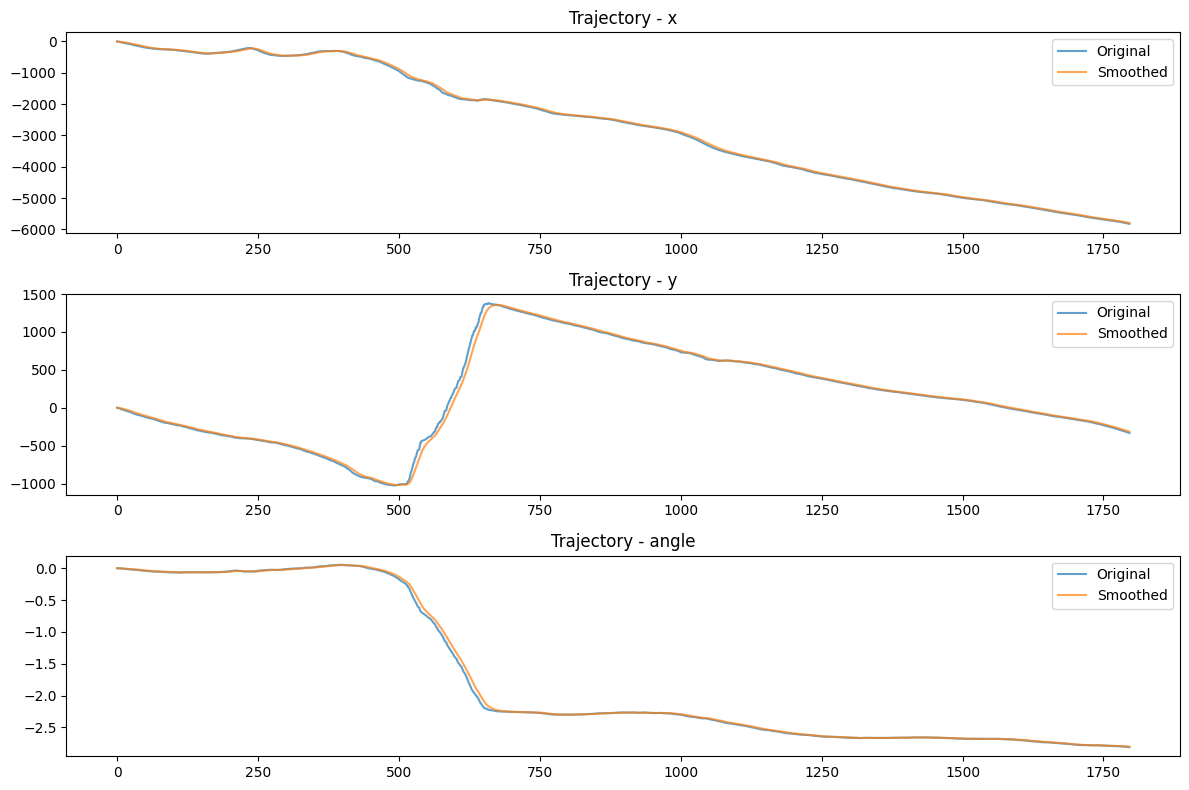

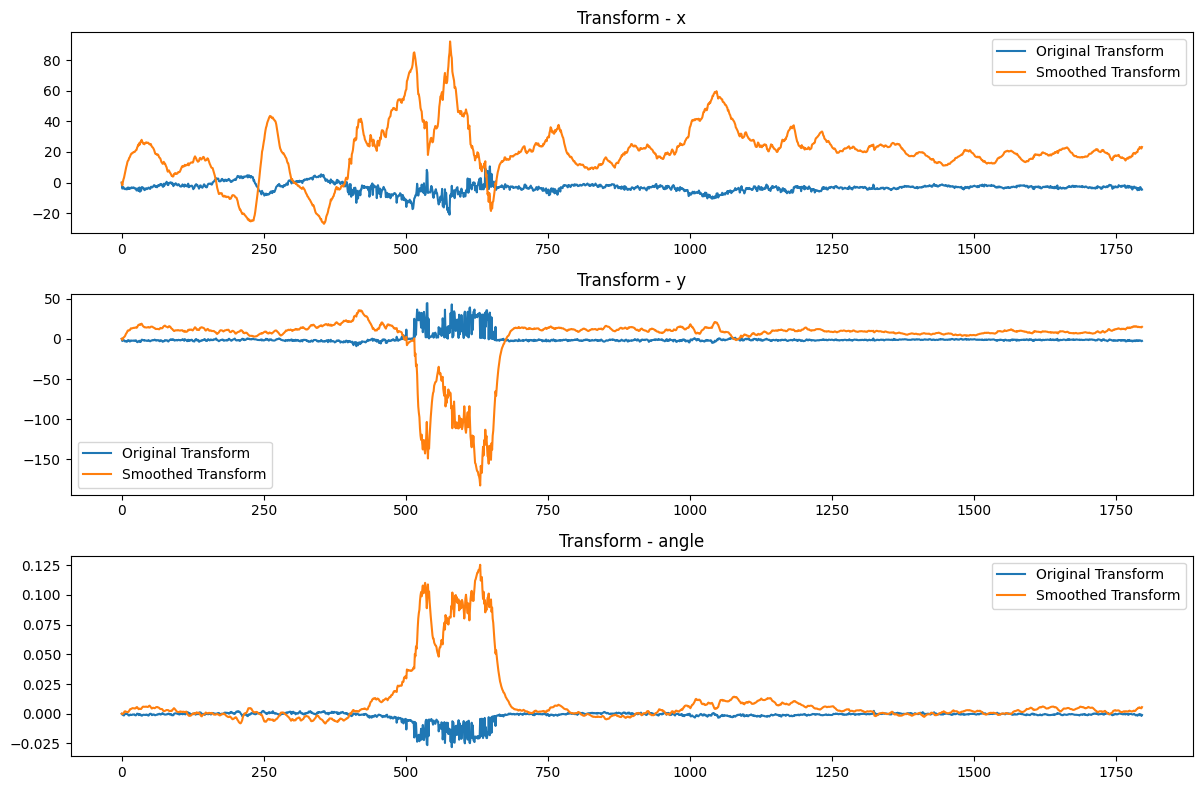

In [19]:
plt.figure(figsize=(12, 8))
labels = ["x", "y", "angle"]
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(trajectory[:, i], label="Original", alpha=0.7)
    plt.plot(smoothed_trajectory[:, i], label="Smoothed", alpha=0.7)
    plt.title(f"Trajectory - {labels[i]}")
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(prev_to_cur_transform[:, i], label="Original Transform")
    plt.plot(new_transforms[:, i], label="Smoothed Transform")
    plt.title(f"Transform - {labels[i]}")
    plt.legend()
plt.tight_layout()
plt.show()